In [1]:
import pandas as pd
import numpy as np
import datetime 
import math
from matplotlib import pyplot as plt
import seaborn as sns

import scipy
import math
from numpy import ndarray
from scipy.optimize import minimize
from typing import Dict, Union, Any, List, Callable
import statistics

In [2]:
%reload_ext autoreload

In [3]:
%autoreload 2

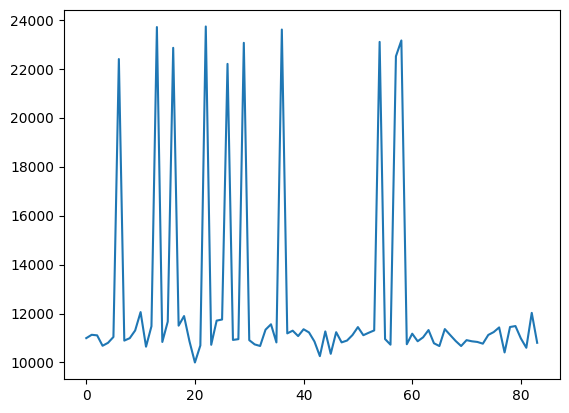

In [8]:
#Dummy dates
ndays = int(60 * 7/5)
base = datetime.date.today()
dates = [base - datetime.timedelta(days = n) for n in range(ndays)]
dates = np.array([x for x in dates if x.weekday() not in [5,6]])

#Dummy volume
vol = 10000
nrows = vol + np.array([int((vol/1000) * (2 + math.sin(i * 2*math.pi/5))) for i in range(ndays)])
sdev = int(vol/25)
nrows = nrows + np.array([int(np.random.normal(0, sdev)) for n in range(ndays)])
nrows = vol + nrows - min(nrows)

mx = np.max(nrows)
for i in range(0, len(nrows)):
    if np.random.uniform() <= 0.10:
        nrows[i] += mx

plt.plot(np.flip(nrows))

In [9]:
rows = [[dt, v] for dt,v in zip(dates, nrows)]
tms_df = pd.DataFrame(rows, columns = ["Date", "Rows"])

date_col: str = "Date"
value_col: str = "Rows"
alpha = 0.05

In [18]:
def extract_axes(
    tms_df: pd.DataFrame, date_col: str = "Date", value_col: str = "Rows"
) -> Union[Dict[str, Any], None]:
    """Returns a t and y axis taken from a pandas DataFrame containing a date and a value column.

    Args:
        tms_df: a pandas DataFrame
        date_col: name of a the column containing the date or timestamps
        value_col: name of the column containing the time series

    Returns:
        A dictionary containing the time series axes

    """
    if date_col not in tms_df.columns or value_col not in tms_df.columns:
        print(f"ERROR: column(s) not found in {tms_df.columns}")
        return None

    tms_df = tms_df.sort_values([date_col], ascending=True).reset_index(drop=True)

    try:
        min_date = tms_df[date_col].min()
        t = np.array([int((x - min_date).total_seconds() / 60) for x in tms_df[date_col]])  # pylint: disable=C0103,R0915

    except ValueError:
        print(
            f"ERROR: column {date_col} is not of type datetime.date or datetime.datetime"
        )
        return None

    y = np.array(tms_df[value_col])
    return {"t": t, "y": y, "y_start": min_date, "y_day": [d.weekday() for d in tms_df[date_col].to_list()]}

In [19]:
axes = extract_axes(tms_df, date_col, value_col)

In [34]:
last_t = axes["t"][-1]
last_y = axes["y"][-1]

# Use the mode of time difference to generate equally spaced points alongside the time domain
t_delta = np.diff(axes["t"])
t_delta_mode = scipy.stats.mode(t_delta, keepdims=False)[0]

# Use interpolation to generate y(t) values
n_points = int(axes["t"][-2] / t_delta_mode)
t = np.linspace(start=0, stop=axes["t"][-2], num=n_points + 1)
y = np.interp(t, axes["t"][:-1], axes["y"][:-1])

# Detrend y
X = np.vstack([np.ones(len(t)), t]).T
c, b = np.linalg.lstsq(X, y, rcond=None)[0]
y_detrend = y - (b * t + c)
y_detrend_cs = (y_detrend - np.mean(y_detrend)) / np.sqrt(np.var(y_detrend))

# Find the highest frequency
acf = np.correlate(y_detrend_cs, y_detrend_cs, "full")[-len(y_detrend) :] / len(
    y_detrend
)

all_freq = np.flip(np.argsort(acf))[1:]
max_freq = len(t) / 2
for i in range(0, len(all_freq)):
    freq = all_freq[i]
    if freq < max_freq:
        break

t_freq = freq * (t[1] - t[0])

# Values for model with lag 
index = np.where(axes["t"] >= t_freq)[0]
y_final = axes["y"][index][:-1]
t_final = axes["t"][index][:-1]
weekday_final = np.array(axes["y_day"])[index][:-1]
y_lag = np.interp(t_final - t_freq, axes["t"][:-1], axes["y"][:-1])

# Check p-value of correlation
lag_cor_val, lag_cor_pval = scipy.stats.pearsonr(y_final, y_lag)
lag_cor_pval = round(lag_cor_pval, 4)

# Intercepts for each day present in the dataset
unique_weekdays = list(set(weekday_final))
unique_weekdays.sort()
n_unique_weekdays = len(unique_weekdays)

weekday_intercepts = [np.zeros(len(t_final)) for i in range(0, n_unique_weekdays)]
for i in range(0, len(weekday_final)):
    weekday = weekday_final[i]
    j = unique_weekdays.index(weekday)
    weekday_intercepts[j][i] = 1

X = np.vstack([np.ones(len(t_final))] + weekday_intercepts + [t_final, y_lag]).T
Y = y_final
# Check p-value of correlation (y_lagged)
cor_val, cor_pval = scipy.stats.pearsonr(y_final, y_lag)

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

In [67]:
weights = np.diag(1/Y)
X_w = np.matmul(weights, X)
Y_w = np.ones(len(Y))

coefs = np.linalg.lstsq(X_w, Y_w, rcond = None)[0]

# Build the X row needed to predict last_y
last_x = [1] + [0 for i in range(0, n_unique_weekdays)] + [0, 0]
last_x[-1] = np.interp(last_t - t_freq, axes["t"][:-1], axes["y"][:-1])
last_x[-2] = last_t
last_weekday = axes["y_day"][-1]
if last_weekday in unique_weekdays:
    i = 1 + unique_weekdays.index(last_weekday)
    last_x[i] = 1

E_last_y = np.matmul(last_x, coefs)
last_y_mape = (last_y - E_last_y) / last_y

In [68]:
# Estimate mape via CV
kf = KFold(n_splits = 5)
kf.get_n_splits(X)

mape = np.zeros(len(Y))
for train_index, test_index in kf.split(X):
    coefs_temp = np.linalg.lstsq(X_w[train_index], Y_w[train_index], rcond = None)[0]
    fitted_val = np.matmul(X[test_index], coefs_temp)
    mape[test_index] = (Y[test_index] - fitted_val) / Y[test_index]

In [71]:
# Obtain cdf value
cm_density = np.linspace(start=0, stop=1, num=len(mape))
mape.sort()
cdf_val = np.interp(last_y_mape, mape, cm_density)
# Obtain p-value of last_y_mape mape
p_val = round(2*min([1-cdf_val, cdf_val]), 4)

In [80]:
coefs = np.round(coefs, 4)

model = {"baseline": coefs[0]}
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
days = [days[i] for i in unique_weekdays]

for i in range(0, len(days)):
    model[days[i]] = coefs[i+1]

model["daily_trend"] = coefs[-2]
model["volume_lagged"] = coefs[-1]

residuals_distribution = {"type": "Percentage error, estimated with CV = 5", "mean": round(statistics.mean(mape), 4), "sdev": round(statistics.stdev(mape), 4)}

In [91]:
fitted_val_noCV = np.matmul(X, coefs)
residuals_noCV = Y - fitted_val_noCV

r_squared = round(np.var(fitted_val_noCV) / np.var(Y), 4)
res_pred_cor = round(scipy.stats.pearsonr(fitted_val_noCV, residuals_noCV)[0], 4)
lag_value = np.round(t_freq / (24 * 60), 2) 
test_result = "FAIL" if p_val <= alpha else "PASS"

baseline = coefs[0]
trend_term = coefs[-2]
lag_term = coefs[-1]

In [92]:
last_y = round(last_y)
E_last_y = round(E_last_y)
delta = E_last_y - last_y

In [93]:
print("------ DELTA TIMESERIES TEST RESULT ------")
print(f"Model r-squared: {r_squared}")
print(f"Correlation between residuals and fitted values: {res_pred_cor}")
print(f"Baseline: {round(baseline)}")
print(f"Daily trend: {trend_term}")
print(f"Y lagged term: {lag_term}")
print(f"Lag (days): {lag_value}")
print("*****")
print(f"Residuals distribution: {residuals_distribution}")
print(f"Observed volume: {last_y}")
print(f"Expected volume: {E_last_y}")
print(f"Percentage change: {round(100*last_y_mape, 2)} %")
print(f"p-value: {p_val}")
print(f"Test alpha: {alpha}")
print(f"Result: {test_result}")
print("------------------------------------------")    

------ DELTA TIMESERIES TEST RESULT ------
Model r-squared: 0.0189
Correlation between residuals and fitted values: 0.297
Baseline: 8586
Daily trend: -0.0039
Y lagged term: 0.1057
Lag (days): 1.0
*****
Residuals distribution: {'type': 'Percentage error, estimated with CV = 5', 'mean': 0.03, 'sdev': 0.1726}
Observed volume: 10804
Expected volume: 11147
Percentage change: -3.17 %
p-value: 0.7933
Test alpha: 0.05
Result: PASS
------------------------------------------


In [94]:
{
        "coefs": model,
        "lag_(days)": lag_value,
        "r_squared": r_squared,
        "fitted_val_and_residuals_correlation": res_pred_cor,
        "volume": {"observed": last_y, "expected": E_last_y, "delta": delta, "delta_percentage": f"{round(100*last_y_mape, 2)} %"},
        "p_value": p_val,
        "test_result": test_result,
        "alpha": alpha,
        "residuals_distribution": residuals_distribution,
        "residuals": list(mape),
    }

{'coefs': {'baseline': 8586.4842,
  'Monday': 2069.1501,
  'Tuesday': 1268.0922,
  'Wednesday': 2028.8138,
  'Thursday': 1479.9022,
  'Friday': 1740.5258,
  'daily_trend': -0.0039,
  'volume_lagged': 0.1057},
 'lag_(days)': 1.0,
 'r_squared': 0.0189,
 'fitted_val_and_residuals_correlation': 0.297,
 'volume': {'observed': 10804,
  'expected': 11147,
  'delta': 343,
  'delta_percentage': '-3.17 %'},
 'p_value': 0.7933,
 'test_result': 'PASS',
 'alpha': 0.05,
 'residuals_distribution': {'type': 'Percentage error, estimated with CV = 5',
  'mean': 0.03,
  'sdev': 0.1726},
 'residuals': [-0.1609770396279788,
  -0.1557411085343842,
  -0.1394423099574254,
  -0.13670018156864178,
  -0.09571767517660004,
  -0.09043941533931242,
  -0.08891167166329507,
  -0.08036887089316386,
  -0.07951350980567001,
  -0.07691514434550094,
  -0.06967205521300861,
  -0.06951397664945609,
  -0.06340940180662631,
  -0.06003701663732679,
  -0.05950940446801639,
  -0.05525116513511707,
  -0.053482742795359146,
  -0.0